# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

**DOUBTS**
- Calcolare alpha e beta per ogni stazione con il fit di scipy? Vanno messe due nuove colonne nel dataset? Se c'è una sola osservazione non posso fare il fit => uniforme? (alpha=1, beta=1)
- Output: AMS o alpha e beta?
- Initial guess? 
- Alpha e beta predetti per ogni stazione come vanno paragonati con quelli "veri"? Intervallo di confidenza sulla media o sui parametri (questo come si calcola) ?
- Come si fa inferenza su più distribuzioni? Quali metriche?
- 20 epoche e 2 hidden impara come 2 epoche e 0 hidden

**TO DO**
- provare con solo MAP in input
- pca?
- nel test ogni stazione ha senso che ci sia una sola volta, tanto l'output sarà sempre lo stesso


# 0. Importing libraries

In [214]:
colab = False

In [215]:
%%capture
if colab:
  !pip install fitter
  !pip install pydot
  !pip install graphviz

In [216]:
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics


from fitter import Fitter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats

if colab:
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

# 1. Load and inspect the dataset

## 1.1. Load data

In [217]:
if colab:
    data_folder = Path.cwd() / "drive" / "MyDrive" / "A3I" / "data"
    dataset_path = data_folder.joinpath("AMS_descritt_noSM_meltD_adim.csv")
    dataset_indexes_test = data_folder.joinpath("gumMap_statbench_Gumfit_NEW.csv")
else:
    dataset_path = "data/AMS_descritt_noSM_meltD_adim.csv"
    dataset_indexes_test = "data/gumMap_statbench_Gumfit_NEW.csv"

df = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)

df_indexes_test = pd.read_csv(dataset_indexes_test, sep=',', encoding='utf-8') #dataset used to extract the ids for test

print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [218]:
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


In [219]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


## 1.2. Preprocess and split the dataset

In [220]:
def standardize(df):
    
    features_not_to_scale = ['ID', 'AMS', 'mean_IdD', 'loc', 'scale']
    features_to_scale = df.columns.drop(features_not_to_scale)

    order_columns = ['ID', 'AMS', 'mean_IdD', 'loc', 'scale'] + list(features_to_scale)

    scaler = MinMaxScaler() #min max scaler to have values in range [0, 1]
    #scaler = StandardScaler() #standard scaler to have values with mean 0 and std 1
    

    scaled_data = scaler.fit_transform(df[features_to_scale])
    non_scaled_data = df[features_not_to_scale]
    std_df = np.concatenate([non_scaled_data, scaled_data], axis=1)

    # convert to dataframe
    
    std_df = pd.DataFrame(std_df, columns=order_columns)

    return std_df

### Split the dataset into train, validation and test

In [221]:
# Take the first 100 ID from df2 and use them to create the test sets
test_ID = df_indexes_test['ID'].to_list()[:100]

# select from df the rows with the ID in test_ID
test_df = df[df['ID'].isin(test_ID)]

In [222]:
# Drop the test set from std_dfs and then create the train sets and validation sets
df = df.drop(df[df['ID'].isin(test_ID)].index)
df.reset_index(drop=True, inplace=True)

validation_split = 0.1
df = df.sort_values(by=['ID'])

train_df, val_df = train_test_split(df, test_size=validation_split, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [223]:
train_df.head()

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h],AMS,mean_IdD,loc,scale
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,1,1.221239,28.250,0.890564,0.184415
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.680425,199.875,0.859361,0.219803
2,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.855535,199.875,0.859361,0.219803
3,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.945591,199.875,0.859361,0.219803
4,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,1.518449,199.875,0.859361,0.219803


### Standardize datasets

In [224]:
train_df_std = standardize(train_df)
val_df_std = standardize(val_df)
test_df_std = standardize(test_df)

In [225]:
# column id must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

In [226]:
train_df_std.head()

,ID,AMS,mean_IdD,loc,scale,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),...,OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]
0,5001,1.221239,28.250,0.890564,0.184415,0.401088,0.297265,0.34667,0.224577,0.842012,...,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,0.0
1,5001,0.680425,199.875,0.859361,0.219803,0.401088,0.297265,0.34667,0.224577,0.842012,...,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.0
2,5001,0.855535,199.875,0.859361,0.219803,0.401088,0.297265,0.34667,0.224577,0.842012,...,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.0
3,5001,0.945591,199.875,0.859361,0.219803,0.401088,0.297265,0.34667,0.224577,0.842012,...,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.0
4,5001,1.518449,199.875,0.859361,0.219803,0.401088,0.297265,0.34667,0.224577,0.842012,...,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.0


In [227]:
train_df_std.describe()

,ID,AMS,mean_IdD,loc,scale,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),...,OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]
count,233218.000000,233218.000000,233218.000000,233218.000000,2.332180e+05,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,...,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000
mean,11047.209328,0.999994,57.052651,0.840404,2.670913e-01,0.166813,0.246883,0.322643,0.308758,0.546673,...,0.219492,0.314823,0.358757,0.272092,0.061749,0.309248,0.093732,0.480096,0.415496,0.356487
std,4333.130131,0.375311,31.051531,0.034366,5.204271e-02,0.157116,0.200644,0.230440,0.194339,0.125339,...,0.149142,0.187693,0.195579,0.168673,0.128670,0.196419,0.148481,0.241816,0.233321,0.360029
min,5001.000000,0.008228,5.200000,0.563792,6.394417e-304,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8094.000000,0.746687,34.984444,0.820754,2.357013e-01,0.049758,0.073997,0.104254,0.166739,0.472726,...,0.132894,0.168426,0.218142,0.139936,0.003447,0.150809,0.017792,0.260888,0.233598,0.086957
50%,12005.000000,0.931278,49.674286,0.841520,2.668687e-01,0.120710,0.221548,0.329908,0.322565,0.546955,...,0.198575,0.289269,0.323356,0.232531,0.007566,0.264866,0.029456,0.517307,0.347570,0.217391
75%,16065.000000,1.171738,70.343750,0.862298,2.976202e-01,0.239505,0.370564,0.483975,0.441252,0.625345,...,0.275427,0.435152,0.459347,0.369040,0.032635,0.433575,0.079028,0.668883,0.599175,0.478261
max,20034.000000,6.288661,318.742857,1.000000,6.725157e-01,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1.4. Prepare data for training

In [228]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'loc', 'scale', 'HMerit_mean(m)',
       'HMerit_stdev(m)', 'Slope_mean(deg)', 'Slope_stdev(deg)',
       'Aspect_mean(deg)', 'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)',
       'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)',
       'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)', 'OrograTirr_stdev(m)',
       'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)',
       'VarClimSowP(mm)', 'X', 'Y', 'duration[h]'],
      dtype='object')

In [229]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_df_std.columns
input_columns = columns[5:] #['MAP(mm)', 'duration[h]'] #['loc', 'scale'] 
output_column = 'AMS'
parameters_columns = ['loc', 'scale']
print('Input columns: ', input_columns)

Input columns:  Index(['HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]'],
      dtype='object')


In [230]:
inputs_train = train_df_std[input_columns]
outputs_train = train_df_std[output_column]
parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns]
outputs_val = val_df_std[output_column]
parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [231]:
for duration in DURATION:
    for id in train_df_std['ID'].unique():
        if len(train_df_std[train_df_std['ID'] == id]) < 10:
            #delete the id from the train set
            train_df_std = train_df_std[train_df_std['ID'] != id]


In [232]:
# # column id must be integer
# for h in DURATION:
#     inputs_train['duration_'+str(h)] = inputs_train['duration_'+str(h)].astype(int)
#     inputs_val['duration_'+str(h)] = inputs_val['duration_'+str(h)].astype(int)
#     inputs_test['duration_'+str(h)] = inputs_test['duration_'+str(h)].astype(int)


In [233]:
inputs_train

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),...,OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]
0,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,0.342076,0.437630,0.507912,...,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,0.000000
1,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,0.342076,0.437630,0.507912,...,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.000000
2,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,0.342076,0.437630,0.507912,...,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.000000
3,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,0.342076,0.437630,0.507912,...,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.000000
4,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,0.304203,0.342076,0.437630,0.507912,...,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233213,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,0.954521,0.397895,0.662771,0.798034,...,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,0.217391
233214,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,0.954521,0.397895,0.662771,0.798034,...,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,0.086957
233215,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,0.954521,0.397895,0.662771,0.798034,...,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,0.086957
233216,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,0.954521,0.397895,0.662771,0.798034,...,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,0.000000


# 2. Model definition

#### Base model

In [234]:
def build_nn_gumbel_model(input_shape, hidden):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    
    mu_logsig = layers.Dense(2, activation='linear')(x)

    lf = lambda t: tfp.distributions.Gumbel(loc=t[:, :1], scale=(1e-6)+tf.math.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsig)
    model = keras.Model(model_in, model_out)
    
    return model

# 3. Metrics 

In [235]:
def sample_metrics(dist, y, label, color, plot = True):
    num_samples = 1
    y_pred = dist.sample(num_samples).numpy().ravel()
    
    mae = metrics.mean_absolute_error(y, y_pred)
    ks_statistics, _ = stats.ks_2samp(y, y_pred)

    if plot:
        plt.hist(y, bins='auto', alpha=0.7, label=label, density=True, color='green');
        #sns.kdeplot(y_pred, label='Estimated sample', fill=True)
        plt.hist(y_pred, bins='auto', alpha=0.5, label='Predicted', density=True, color=color);
        plt.legend()
        plt.show()

    return mae, ks_statistics

def plot_series(data, labels=None, predictions=None, figsize=None, filled_version=None, std=None, ci=None, title=None, ylim=None):
    
    plt.figure(figsize=figsize)
    plt.plot(data.index, data.values, zorder=0)
    
    if filled_version is not None:
        filled = filled_version.copy()
        filled[~data['value'].isnull()] = np.nan
        plt.scatter(filled.index, filled, marker='.', c='tab:orange', s=5);
    
    # Plot standard deviations
    if std is not None:
        lb = data.values.ravel() - std.values.ravel()
        ub = data.values.ravel() + std.values.ravel()
        plt.fill_between(data.index, lb, ub, alpha=0.3, label='+/- std')
    
    # Plot confidence intervals
    if ci is not None:
        lb = ci[0].ravel()
        ub = ci[1].ravel()
        plt.fill_between(data.index, lb, ub, alpha=0.3, label='C.I.')
    
    # Rotated x ticks
    plt.xticks(rotation=45)
    
    # Plot labels
    if labels is not None:
        plt.scatter(labels.values, data.loc[labels], color='red', zorder=2, s=5)
    
    # Predictions
    if predictions is not None:
        plt.scatter(predictions.values, data.loc[predictions], color='black', alpha=.4, zorder=3, s=5)
    
    # Force y limits
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.grid(linestyle=':')
    plt.title(title)
    plt.tight_layout()

def percentage_in_ci(inputs, y, dist, confidence, distribution = 'gumbel', start = None, end = None, plot = True, num_samples=1):
    
    if start is None:
        start = 0
    if end is None:
        end = len(y)

    if distribution == 'gumbel':
        lb, ub = stats.gumbel_r.interval(confidence, loc=dist.loc, scale=dist.scale)
        mean_dist = dist.mean().numpy().ravel()
        y_pred = dist.sample(num_samples).numpy().ravel()

        if plot:
            plot_series(pd.Series(index=inputs[start:end].index, data=mean_dist[start:end]), ci=(lb[start:end], ub[start:end]), figsize=(12,6))
            plt.scatter(inputs[start:end].index, y_pred[start:end], marker='o', color='blue', label='Predicted');
            plt.scatter(inputs[start:end].index, y[start:end], marker='x', color='red', label='True');
            plt.legend()
            plt.show()
    
        count_true = 0
        for i in range(len(y)):
            if lb[i] <= y[i] <= ub[i]:
                count_true += 1
        
        true_guess = count_true/len(y)*100

        return true_guess

# 4. Training

In [236]:
def train_nn_model(model, X, y, batch_size, loss, lr, verbose=0, patience=10, validation_data=None, **fit_params):
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)
    
    # Build the early stop callback
    cb = []
    if validation_data is not None:
        cb += [callbacks.EarlyStopping(patience=patience, restore_best_weights=True)]
    
    # Train the model
    history = model.fit(X, y, batch_size=batch_size, callbacks=cb, validation_data=validation_data, verbose=verbose, **fit_params)
    
    return history

def plot_training_history(history=None, figsize=None, print_final_scores=True):
    plt.figure(figsize=figsize)
    for metric in history.history.keys():
        plt.plot(history.history[metric], label=metric)
    
    if len(history.history.keys()) > 0:
        plt.legend()
    plt.xlabel('epochs')
    plt.grid(linestyle=':')
    plt.tight_layout()
    plt.show()
    
    if print_final_scores:
        trl = history.history["loss"][-1]
        s = f'Final loss: {trl:.4f} (training)'
        if 'val_loss' in history.history:
            vll = history.history["val_loss"][-1]
            s += f', {vll:.4f} (validation)'
        print(s)

## Training

In [237]:
X_train = inputs_train.values
y_train  = outputs_train.values
X_val = inputs_val.values
y_val = outputs_val.values
X_test = inputs_test.values
y_test = outputs_test.values

In [238]:
# Parameters for the training
batch_size = 450
epochs = 90
lr = 1e-3
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

print('Training the model without the guesses...')
model = build_nn_gumbel_model(input_shape=(X_train.shape[1],), hidden=[256,128])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, mode='auto', min_delta=1e-3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_prof)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callback], verbose=1)
plot_training_history(history, figsize=(14, 4))

Training the model without the guesses...
Epoch 1/90
507/519 [============================>.] - ETA: 0s - loss: 0.3267

519/519 [==============================] - 3s 5ms/step - loss: 0.3258 - val_loss: 0.3227
Epoch 2/90
519/519 [==============================] - 2s 4ms/step - loss: 0.3006 - val_loss: 0.3526
Epoch 3/90
519/519 [==============================] - 2s 4ms/step - loss: 0.2997 - val_loss: 0.2790
Epoch 4/90
519/519 [==============================] - 2s 4ms/step - loss: 0.2985 - val_loss: 0.3108
Epoch 5/90
519/519 [==============================] - 2s 4ms/step - loss: 0.2977 - val_loss: 0.3627
Epoch 6/90
519/519 [==============================] - 2s 4ms/step - loss: 0.2975 - val_loss: 0.3341
Epoch 7/90
519/519 [==============================] - 2s 4ms/step - loss: 0.2973 - val_loss: 0.3208
Epoch 8/90
519/519 [==============================] - 2s 4ms/step - loss: 0.2970 - val_loss: 0.3150
Epoch 9/90
519/519 [==============================] - 2s 4ms/step - loss: 0.2958 - val_loss: 0.3609
Epoch 10/90
519/519 [==============================] - 2s 4ms/step - loss: 0.2955 - val_loss: 0.3087
Epoch 11/9

* Train evaluation

Evaluating the models on training set...


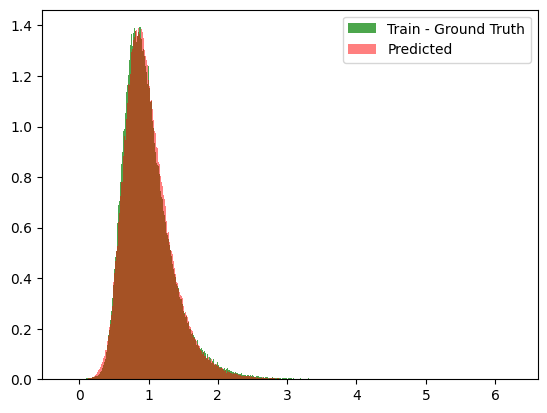

Train:
MAE: 0.38
KS statistics: 0.02


In [ ]:
print('Evaluating the models on training set...')

dist_train = model(X_train)
mae_train, ks_statist_train = sample_metrics(dist_train, y_train, 'Train - Ground Truth', 'red')
print('Train:')
print(f'MAE: {mae_train:.2f}')
print(f'KS statistics: {ks_statist_train:.2f}')

# Store the results in a dataframe
results = pd.DataFrame(columns=['Split', 'MAE', 'KS statistics'])

train_no_guess = ['Train', mae_train, ks_statist_train]
results.loc[0] = train_no_guess

* Validation evaluation

Evaluating the models on validation set...


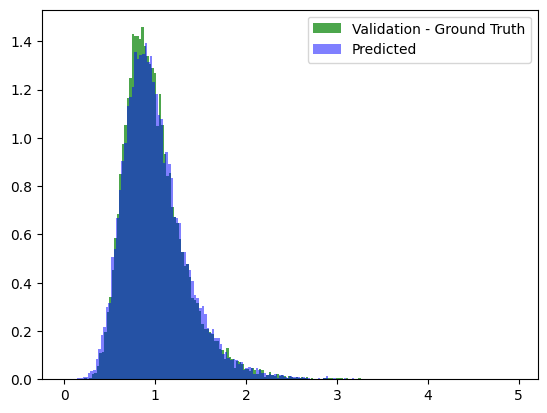

Validation:
MAE: 0.38
KS statistics: 0.02


In [ ]:
print('Evaluating the models on validation set...')

dist_val = model(X_val)
mae_val, ks_statist_val = sample_metrics(dist_val, y_val, 'Validation - Ground Truth', 'blue')
print('Validation:')
print(f'MAE: {mae_val:.2f}')
print(f'KS statistics: {ks_statist_val:.2f}')

val_no_guess = ['Validation', mae_val, ks_statist_val]
results.loc[1] = val_no_guess

## Evaluation and predictions on test set

Evaluating the models on test set...


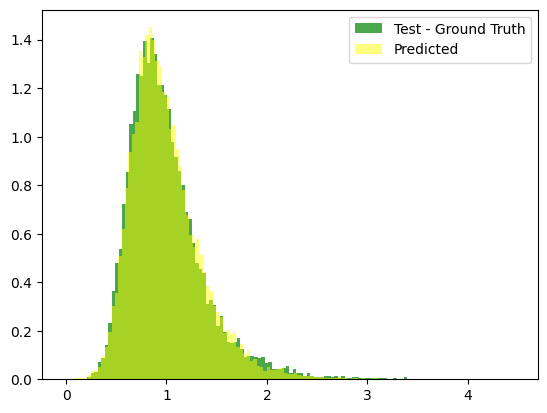

Test:
MAE: 0.39
KS statistics: 0.02


In [ ]:
print('Evaluating the models on test set...')

dist_test = model(X_test)
mae_test, ks_statist_test = sample_metrics(dist_test, y_test, 'Test - Ground Truth', 'yellow')
print('Test:')
print(f'MAE: {mae_test:.2f}')
print(f'KS statistics: {ks_statist_test:.2f}')

test_no_guess = ['Test', mae_test, ks_statist_test]
results.loc[2] = test_no_guess

In [ ]:
display(results)

,Split,MAE,KS statistics
0,Train,0.387037,0.011762
1,Validation,0.377697,0.028363
2,Test,0.396092,0.012845


* Distribution mean - confidence interval 

Evaluation based on confidence intervals..


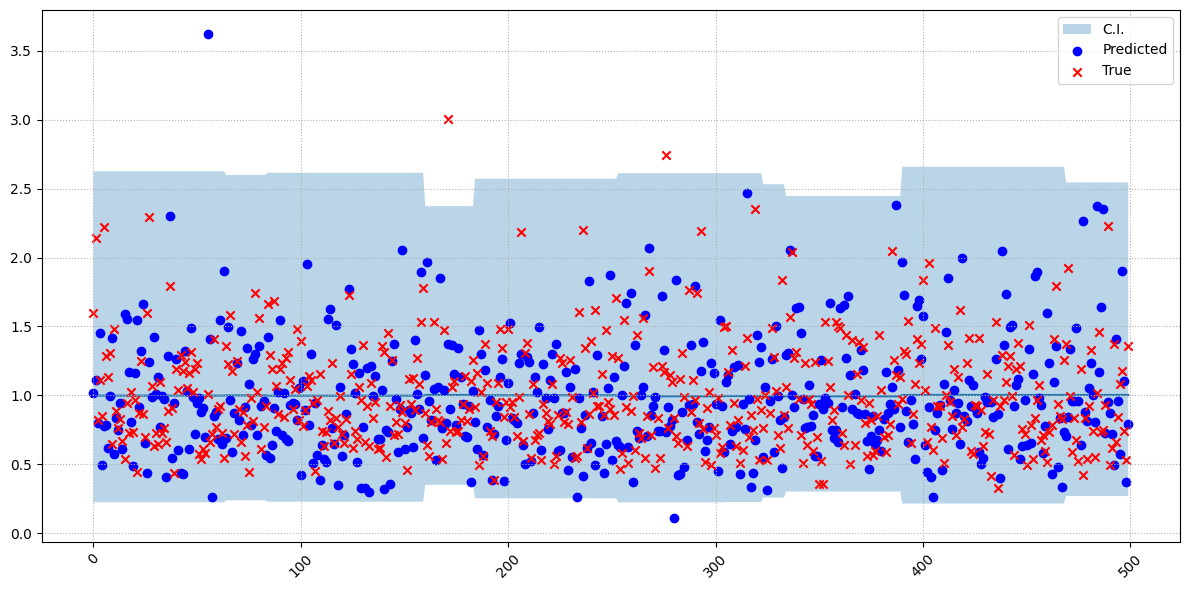

Percentage of values inside the 99% confidence interval: 97.96%


In [ ]:
confidence = 0.99

print('Evaluation based on confidence intervals..')

inside = percentage_in_ci(inputs_test, y_test, dist_test, confidence, end = 500)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

### Parameters

In [ ]:
scale_pred.max()

0.38559914

In [ ]:
parameters_train['scale'].max()

0.672515700467173

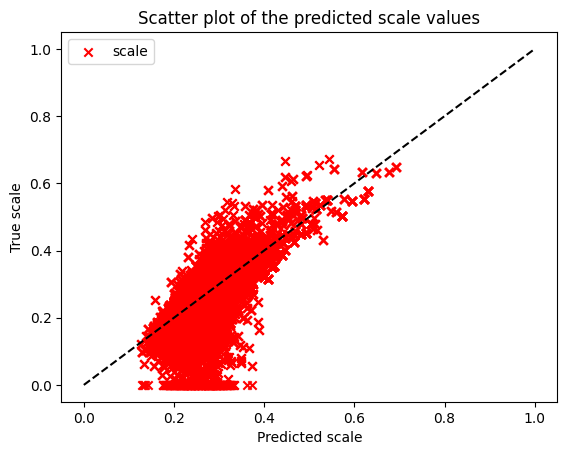

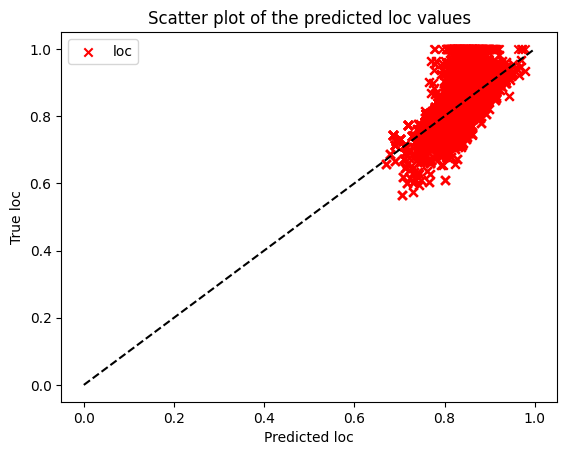

In [ ]:
scale_pred = dist_train.scale.numpy()
# scatter plot of the predicted alpha values
plt.scatter(scale_pred, parameters_train['scale'], color='red', label='scale', marker='x')
# add bisector line
x = np.linspace(0, 1, 100)
plt.plot(x, x, color='black', linestyle='--')
plt.xlabel('Predicted scale')
plt.ylabel('True scale')
plt.legend()
plt.title('Scatter plot of the predicted scale values')
plt.show()


loc_pred = dist_train.loc.numpy()
# scatter plot of the predicted alpha values
plt.scatter(loc_pred, parameters_train['loc'], color='red', label='loc', marker='x')
# add bisector line
x = np.linspace(0, 1, 100)
plt.plot(x, x, color='black', linestyle='--')
plt.xlabel('Predicted loc')
plt.ylabel('True loc')
plt.legend()
plt.title('Scatter plot of the predicted loc values')
plt.show()

* Metrics for parameters

In [ ]:
# calculate the biasr for the scale parameter

scale_pred = dist_train.scale.numpy().ravel()
scale_true = parameters_train['scale']

# calculate the biasr
biasr = ((scale_true - scale_pred) / scale_true).mean()
print(f'Biasr for the scale parameter: {biasr:.2f}')

#rmse
rmse = metrics.mean_squared_error(scale_true, scale_pred, squared=False)
print(f'RMSE for the scale parameter: {rmse:.2f}')

#pcc
pcc = np.corrcoef(scale_true, scale_pred)[0, 1]
print(f'PCC for the scale parameter: {pcc:.2f}')

Biasr for the scale parameter: -467372471371740234713256606718747284355223079342741288172114672443184064804219712639822874644202292275609591314365378718754126557957594035774385826426227840043166167906884803679588300483915545582580408223457951894186489993576918055967622548332439920002677994127989311263937558317149902293786454654976.00
RMSE for the scale parameter: 0.04
PCC for the scale parameter: 0.61


In [ ]:
# calculate the biasr for the loc parameter

loc_true = parameters_train['loc'].to_numpy()
loc_pred = dist_train.loc.numpy().ravel()

# calculate the biasr
biasr = ((loc_true - loc_pred) / loc_true).mean()
print(f'Biasr for the loc parameter: {biasr:.2f}')

#rmse
rmse = metrics.mean_squared_error(loc_true, loc_pred, squared=False)
print(f'RMSE for the loc parameter: {rmse:.2f}')

#pcc
pcc = np.corrcoef(loc_true, loc_pred)[0, 1]
print(f'PCC for the loc parameter: {pcc:.2f}')

Biasr for the loc parameter: 0.01
RMSE for the loc parameter: 0.03
PCC for the loc parameter: 0.61
